In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PyPDF2 as p2

In [2]:
columns = ['eprtrSectorName', 'reportingYear', 'pollutant',
           'MONTH', 'DAY', 'max_wind_speed', 'avg_wind_speed', 'min_wind_speed', 
           'max_temp', 'avg_temp', 'min_temp', 'DAY WITH FOGS']

train1 = pd.read_csv("train1.csv")[columns]
train2 = pd.read_csv("train2.csv", sep=";", error_bad_lines=False)[columns]

url = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com"

json1 = pd.read_json(url+"/first")[columns]
json2 = pd.read_json(url+"/second")[columns]
json3 = pd.read_json(url+"/third")[columns]

#======pdf================
col_esn = []; col_year = []; col_poll = []; col_month = []; col_day = []; 
col_maxws = []; col_avgws = []; col_minws = []; col_maxtemp = []; 
col_avgtemp = []; col_mintemp = []; col_dwf = []

for i in range(15, 97):
  try:
    f = open(f"train6/pdfs815{i}.pdf", "rb")
    readf = p2.PdfFileReader(f)
    x1 = readf.getPage(0).extractText().replace(" ", "")
    col_esn.append(x1.split()[17])
    col_year.append(x1.split()[31]); col_poll.append(x1.split()[23])
    col_month.append(x1.split()[29]); col_day.append(x1.split()[27])
    col_maxws.append(x1.split()[34]); col_avgws.append(x1.split()[38])
    col_minws.append(x1.split()[36]); col_maxtemp.append(x1.split()[40])
    col_avgtemp.append(x1.split()[44]); col_mintemp.append(x1.split()[42])
    col_dwf.append(x1.split()[46])
    f.close()
  except FileNotFoundError as f:
    print(f"error file {i}")

pdf_df = pd.DataFrame({
    "eprtrSectorName": col_esn,
    "reportingYear": [int(i) for i in col_year],
    "pollutant": col_poll,
    "MONTH": [int(i) for i in col_month],
    "DAY": [int(i) for i in  col_day],
    "max_wind_speed": [float(i[:-4].replace(",",".")) for i in col_maxws],
    "avg_wind_speed": [float(i[:-4].replace(",",".")) for i in col_avgws],
    "min_wind_speed": [float(i[:-4].replace(",",".")) for i in col_minws],
    "max_temp": [float(i[:-4].replace(",",".")) for i in col_maxtemp],
    "avg_temp": [float(i[:-4].replace(",",".")) for i in col_avgtemp],
    "min_temp": [float(i[:-4].replace(",",".")) for i in col_mintemp],
    "DAY WITH FOGS": [int(i) for i in col_dwf]
})

df = pd.concat([train1,train2,json1,json2,json3,pdf_df], ignore_index=True)
df['pollutant']=df['pollutant'].str.replace(" ", "")
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


error file 65


,eprtrSectorName,reportingYear,pollutant,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
0,Mineral industry,2015,Carbondioxide(CO2),10,20,15.118767,14.312541,21.419106,2.864895,4.924169,9.688206,2
1,Mineral industry,2018,Nitrogenoxides(NOX),9,21,19.661550,19.368166,21.756389,5.462839,7.864403,12.023521,1
2,Waste and wastewater management,2019,Methane(CH4),2,4,12.729453,14.701985,17.103930,1.511201,4.233438,8.632193,2
3,Energy sector,2012,Nitrogenoxides(NOX),8,6,11.856417,16.122584,17.537184,10.970301,10.298348,15.179215,0
4,Waste and wastewater management,2018,Methane(CH4),12,22,17.111930,20.201604,21.536012,11.772039,11.344078,16.039004,2


In [3]:
from sklearn.preprocessing import MinMaxScaler
df["reportingYear"] = pd.qcut(df['reportingYear'], 4, labels=False)

df['pollutant']=(df['pollutant']
  .replace(["Nitrogenoxides(NOX)", 'Carbondioxide(CO2)', 'Methane(CH4)'], 
           [0, 1, 2])
)
df['eprtrSectorName'] = (
    df['eprtrSectorName'].replace(
        ['Wasteandwastewatermanagement', 'Paperandwoodproductionandprocessing', 
         'Chemicalindustry', 'Mineralindustry', 'Energysector'],
        ['Waste and wastewater management', 'Paper and wood production and processing', 
         'Chemical industry', 'Mineral industry', 'Energy sector']
    )
)

df = pd.get_dummies(df, columns=['eprtrSectorName'], drop_first=True)

df.head()

,reportingYear,pollutant,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,eprtrSectorName_Chemical industry,eprtrSectorName_Energy sector,eprtrSectorName_Intensive livestock production and aquaculture,eprtrSectorName_Mineral industry,eprtrSectorName_Other activities,eprtrSectorName_Paper and wood production and processing,eprtrSectorName_Production and processing of metals,eprtrSectorName_Waste and wastewater management
0,2,1,10,20,15.118767,14.312541,21.419106,2.864895,4.924169,9.688206,2,0,0,0,1,0,0,0,0
1,3,0,9,21,19.661550,19.368166,21.756389,5.462839,7.864403,12.023521,1,0,0,0,1,0,0,0,0
2,3,2,2,4,12.729453,14.701985,17.103930,1.511201,4.233438,8.632193,2,0,0,0,0,0,0,0,1
3,1,0,8,6,11.856417,16.122584,17.537184,10.970301,10.298348,15.179215,0,0,1,0,0,0,0,0,0
4,3,2,12,22,17.111930,20.201604,21.536012,11.772039,11.344078,16.039004,2,0,0,0,0,0,0,0,1


In [4]:
scaler = MinMaxScaler()
df[['reportingYear', 'MONTH', 'DAY', 'max_wind_speed', 'avg_wind_speed', 
    'min_wind_speed', 'max_temp', 'avg_temp', 'min_temp']] = scaler.fit_transform(df[['reportingYear', 'MONTH', 'DAY', 'max_wind_speed', 'avg_wind_speed', 
    'min_wind_speed', 'max_temp', 'avg_temp', 'min_temp']])
df.head()

,reportingYear,pollutant,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,eprtrSectorName_Chemical industry,eprtrSectorName_Energy sector,eprtrSectorName_Intensive livestock production and aquaculture,eprtrSectorName_Mineral industry,eprtrSectorName_Other activities,eprtrSectorName_Paper and wood production and processing,eprtrSectorName_Production and processing of metals,eprtrSectorName_Waste and wastewater management
0,0.666667,1,0.818182,0.703704,0.641688,0.626823,0.699173,0.249436,0.314744,0.366280,2,0,0,0,1,0,0,0,0
1,1.000000,0,0.727273,0.740741,0.848447,0.872242,0.711089,0.357326,0.448394,0.463555,1,0,0,0,1,0,0,0,0
2,1.000000,2,0.090909,0.111111,0.532941,0.645728,0.546712,0.193219,0.283346,0.322292,2,0,0,0,0,0,0,0,1
3,0.333333,0,0.636364,0.185185,0.493206,0.714689,0.562020,0.586043,0.559031,0.595002,0,0,1,0,0,0,0,0,0
4,1.000000,2,1.000000,0.777778,0.732404,0.912700,0.703303,0.619338,0.606565,0.630816,2,0,0,0,0,0,0,0,1


In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE

X = df.drop("pollutant", axis=1)
y = df['pollutant']

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, random_state=42)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

tcmalloc: large alloc 1073741824 bytes == 0x85fc000 @  0x7f4b302191e7 0x7f4b21b760ce 0x7f4b21bcccf5 0x7f4b21bcce08 0x7f4b21c8c0f4 0x7f4b21c8ef6d 0x7f4b21e1349b 0x7f4b21e153a3 0x7f4b21e16e10 0x59588e 0x595b69 0x4d0bb9 0x514365 0x549e0e 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x549e0e 0x4bca8a 0x5134a6 0x549e0e 0x4bca8a 0x5134a6 0x549e0e 0x4bca8a 0x5134a6 0x598ef4 0x5a7284


Shape of X before SMOTE: (65709, 18)
Shape of X after SMOTE: (78003, 18)

Balance of positive and negative classes (%):


1    33.333333
0    33.333333
2    33.333333
Name: pollutant, dtype: float64

## Train with 7 models

In [7]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

modelos = {
    "XGB": XGBClassifier(),
    "LGB": LGBMClassifier(),
    "MLP": MLPClassifier(max_iter=5000),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier(),
    "DTC": DecisionTreeClassifier(),
    "KNC": KNeighborsClassifier()
}

for name, model in modelos.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  f1 = f1_score(y_test, y_pred, average="macro")
  print(f"F1 {name:<5}: {f1:.3f}")

[19:51:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 XGB  : 0.620
F1 LGB  : 0.611
F1 MLP  : 0.579
F1 RFC  : 0.677
F1 ABC  : 0.586
F1 DTC  : 0.610
F1 KNC  : 0.612


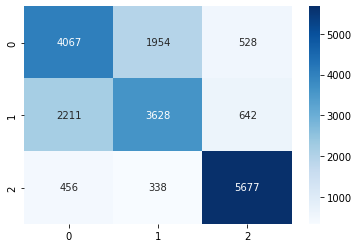

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
modelo = RandomForestClassifier().fit(X_train, y_train)
cm = confusion_matrix(y_test, modelo.predict(X_test))
sns.heatmap(cm, cmap="Blues", annot=True, fmt='d');

In [9]:
print(classification_report(y_test, modelo.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61      6549
           1       0.61      0.56      0.59      6481
           2       0.83      0.88      0.85      6471

    accuracy                           0.69     19501
   macro avg       0.68      0.69      0.68     19501
weighted avg       0.68      0.69      0.68     19501



In [10]:
df_test = pd.read_csv("test_x.csv")[['eprtrSectorName', 'reportingYear',
           'MONTH', 'DAY', 'max_wind_speed', 'avg_wind_speed', 'min_wind_speed', 
           'max_temp', 'avg_temp', 'min_temp', 'DAY WITH FOGS']]
df_test.head()

,eprtrSectorName,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
0,Mineral industry,2017,8,16,14.080054,14.855940,18.474836,10.278561,11.381181,13.480752,1
1,Waste and wastewater management,2008,11,22,16.052425,17.623877,22.622900,6.625910,8.840137,13.422924,0
2,Energy sector,2014,9,19,13.647318,15.541979,17.818521,5.669436,8.403322,11.276388,2
3,Waste and wastewater management,2011,7,17,16.336762,17.458113,19.961777,6.160560,7.571596,9.443572,2
4,Energy sector,2010,6,23,21.516602,20.532473,21.617137,10.964012,11.548033,12.624114,2


In [11]:
df_test["reportingYear"] = pd.qcut(df_test['reportingYear'], 4, labels=False)

df_test['eprtrSectorName'] = (
    df_test['eprtrSectorName'].replace(
        ['Wasteandwastewatermanagement', 'Paperandwoodproductionandprocessing', 'Chemicalindustry'],
        ['Waste and wastewater management', 'Paper and wood production and processing', 'Chemical industry']
    )
)

df_test = pd.get_dummies(df_test, columns=['eprtrSectorName'], drop_first=True)
scaler = MinMaxScaler()
df_test[['reportingYear', 'MONTH', 'DAY', 'max_wind_speed', 'avg_wind_speed', 
    'min_wind_speed', 'max_temp', 'avg_temp', 'min_temp']] = scaler.fit_transform(df_test[['reportingYear', 'MONTH', 'DAY', 'max_wind_speed', 'avg_wind_speed', 
    'min_wind_speed', 'max_temp', 'avg_temp', 'min_temp']])
df_test.head()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,eprtrSectorName_Chemical industry,eprtrSectorName_Energy sector,eprtrSectorName_Intensive livestock production and aquaculture,eprtrSectorName_Mineral industry,eprtrSectorName_Other activities,eprtrSectorName_Paper and wood production and processing,eprtrSectorName_Production and processing of metals,eprtrSectorName_Waste and wastewater management
0,1.000000,0.636364,0.555556,0.405893,0.106976,0.228898,0.558830,0.573356,0.523458,1,0,0,0,1,0,0,0,0
1,0.000000,0.909091,0.777778,0.538447,0.453030,0.507603,0.406936,0.447554,0.521054,0,0,0,0,0,0,0,0,1
2,0.666667,0.727273,0.666667,0.376810,0.192747,0.184801,0.367161,0.425928,0.431825,2,0,1,0,0,0,0,0,0
3,0.333333,0.545455,0.592593,0.557556,0.432306,0.328805,0.387584,0.384751,0.355636,2,0,0,0,0,0,0,0,1
4,0.000000,0.454545,0.814815,0.905671,0.816670,0.440027,0.587335,0.581617,0.487848,2,0,1,0,0,0,0,0,0


In [12]:
submit = pd.DataFrame({
    "test_index": pd.read_csv("test_x.csv")['test_index'],
    "pollutant": modelo.predict(df_test)   
})
submit.head()

,test_index,pollutant
0,0,1
1,1,2
2,2,0
3,3,2
4,4,1


In [13]:
submit.to_csv("predictions.csv", index=False)

In [14]:
submit.to_csv("predictions.json", index=False)